# Analiza skenova iz IXI skupa podataka

In [ ]:
#import potrebnih knjižnica
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
import glob
import re
import os
import numpy as np

In [2]:
t1_dir = "../dataset/raw_data/IXI-T1"
t2_dir = "../dataset/raw_data/IXI-T2"

t1_files = sorted(glob.glob(os.path.join(t1_dir, "*.nii*")))
t2_files = sorted(glob.glob(os.path.join(t2_dir, "*.nii*")))

In [3]:
# Funkcija za izvlačenje ID subjekta iz imena datoteke
def extract_subject_id(filename):
    match = re.search(r'IXI(\d+)', os.path.basename(filename))
    if match:
        return match.group(0)
    return os.path.basename(filename).split('-')[0]

In [4]:
t1_ids = {extract_subject_id(f): f for f in t1_files}
t2_ids = {extract_subject_id(f): f for f in t2_files}

In [5]:
print(f"Pronađeno {len(t1_files)} T1 skenova")
print(f"Pronađeno {len(t2_files)} T2 skenova")

# Pronađi zajedničke ID-ove (koji postoje u oba direktorija)
common_ids = set(t1_ids.keys()) & set(t2_ids.keys())
t1_only_ids = set(t1_ids.keys()) - common_ids
t2_only_ids = set(t2_ids.keys()) - common_ids

print(f"\nBroj zajedničkih subjekata: {len(common_ids)}")
print(f"Broj T1 skenova bez T2 para: {len(t1_only_ids)}")
print(f"Broj T2 skenova bez T1 para: {len(t2_only_ids)}")

Pronađeno 581 T1 skenova
Pronađeno 578 T2 skenova

Broj zajedničkih subjekata: 577
Broj T1 skenova bez T2 para: 4
Broj T2 skenova bez T1 para: 1


In [6]:
t1_to_delete = [t1_ids[subject_id] for subject_id in t1_only_ids]
t2_to_delete = [t2_ids[subject_id] for subject_id in t2_only_ids]

# Ispis datoteka koje će biti izbrisane
print("\nT1 datoteke za brisanje:")
for f in t1_to_delete:
    print(f"- {os.path.basename(f)}")

print("\nT2 datoteke za brisanje:")
for f in t2_to_delete:
    print(f"- {os.path.basename(f)}")

confirmation = input("\nŽelite li nastaviti s brisanjem ovih datoteka? (da/ne): ")

if confirmation.lower() == 'da':
    for f in t1_to_delete:
        os.remove(f)
    for f in t2_to_delete:
        os.remove(f)
    print(f"\nIzbrisano {len(t1_to_delete)} T1 datoteka i {len(t2_to_delete)} T2 datoteka.")
    
    t1_files = sorted(glob.glob(os.path.join(t1_dir, "*.nii*")))
    t2_files = sorted(glob.glob(os.path.join(t2_dir, "*.nii*")))
    print(f"Preostalo {len(t1_files)} T1 skenova i {len(t2_files)} T2 skenova.")
else:
    print("\nBrisanje otkazano.")

if confirmation.lower() == 'da':
    print("\nPrvih 5 zajedničkih parova:")
    common_ids_list = sorted(list(common_ids))
    for i, subject_id in enumerate(common_ids_list[:5]):
        print(f"{i+1}. {subject_id}: {os.path.basename(t1_ids[subject_id])} | {os.path.basename(t2_ids[subject_id])}")


T1 datoteke za brisanje:
- IXI182-Guys-0792-T1.nii.gz
- IXI500-Guys-1017-T1.nii.gz
- IXI116-Guys-0739-T1.nii.gz
- IXI309-IOP-0897-T1.nii.gz

T2 datoteke za brisanje:
- IXI580-IOP-1157-T2.nii.gz

Izbrisano 4 T1 datoteka i 1 T2 datoteka.
Preostalo 577 T1 skenova i 577 T2 skenova.

Prvih 5 zajedničkih parova:
1. IXI002: IXI002-Guys-0828-T1.nii.gz | IXI002-Guys-0828-T2.nii.gz
2. IXI012: IXI012-HH-1211-T1.nii.gz | IXI012-HH-1211-T2.nii.gz
3. IXI013: IXI013-HH-1212-T1.nii.gz | IXI013-HH-1212-T2.nii.gz
4. IXI014: IXI014-HH-1236-T1.nii.gz | IXI014-HH-1236-T2.nii.gz
5. IXI015: IXI015-HH-1258-T1.nii.gz | IXI015-HH-1258-T2.nii.gz


In [7]:
#provjeri jesu li svi skenovi u oba direktorija u paru, ali ne samo po ID-u vec po cijelom nazivu datoteke (npr. IXI012-HH-1211-T1.nii.gz i IXI012-HH-1211-T2.nii.gz)
def get_pair_filename(filename, source_dir, target_dir):
    base_name = os.path.basename(filename)
    paired_name = base_name.replace('T1', 'T2')
    paired_path = os.path.join(target_dir, paired_name)
    
    return paired_path, paired_name

# Provjeri parove T1 → T2
t1_missing_pairs = []
t1_with_pairs = []

for t1_file in t1_files:
    t2_pair_path, t2_pair_name = get_pair_filename(t1_file, t1_dir, t2_dir)
    
    if os.path.exists(t2_pair_path):
        t1_with_pairs.append((t1_file, t2_pair_path))
    else:
        t1_missing_pairs.append((t1_file, t2_pair_name))

t2_missing_pairs = []
t2_with_pairs = []

for t2_file in t2_files:
    t1_pair_path, t1_pair_name = get_pair_filename(t2_file, t2_dir, t1_dir)
    t1_pair_path = t1_pair_path.replace('T2', 'T1')
    
    if os.path.exists(t1_pair_path):
        t2_with_pairs.append((t2_file, t1_pair_path))
    else:
        t2_missing_pairs.append((t2_file, t1_pair_name.replace('T2', 'T1')))

# Ispis rezultata
print(f"\nBroj T1 skenova s odgovarajućim T2 parom: {len(t1_with_pairs)}")
print(f"Broj T1 skenova bez odgovarajućeg T2 para: {len(t1_missing_pairs)}")
print(f"Broj T2 skenova bez odgovarajućeg T1 para: {len(t2_missing_pairs)}")


Broj T1 skenova s odgovarajućim T2 parom: 577
Broj T1 skenova bez odgovarajućeg T2 para: 0
Broj T2 skenova bez odgovarajućeg T1 para: 0


T1 orijentacija: ('P', 'S', 'R')
T2 orijentacija: ('L', 'A', 'S')
T1 oblik: (256, 256, 150)
T2 oblik: (256, 256, 130)


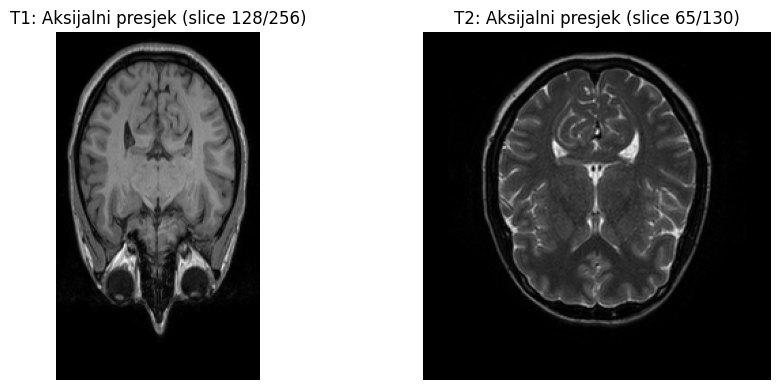

In [8]:
def visualize_axial_slices_fixed(t1_path, t2_path, slice_percentage=0.5):
    t1_img = nib.load(t1_path)
    t2_img = nib.load(t2_path)
    t1_data = t1_img.get_fdata()
    t2_data = t2_img.get_fdata()
    
    t1_orientation = nib.orientations.aff2axcodes(t1_img.affine)
    t2_orientation = nib.orientations.aff2axcodes(t2_img.affine)
    
    print(f"T1 orijentacija: {t1_orientation}")
    print(f"T2 orijentacija: {t2_orientation}")
    print(f"T1 oblik: {t1_data.shape}")
    print(f"T2 oblik: {t2_data.shape}")
    
    t1_slice_idx = int(t1_data.shape[1] * slice_percentage)  # Za T1, koristimo drugi indeks
    t2_slice_idx = int(t2_data.shape[2] * slice_percentage)  # Za T2, koristimo treći indeks
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    t1_axial = t1_data[:, t1_slice_idx, :]
    axes[0].imshow(np.rot90(t1_axial.T), cmap='gray')
    axes[0].set_title(f'T1: Aksijalni presjek (slice {t1_slice_idx}/{t1_data.shape[1]})')
    axes[0].axis('off')
    
    t2_axial = t2_data[:, :, t2_slice_idx]
    axes[1].imshow(t2_axial.T, cmap='gray')
    axes[1].set_title(f'T2: Aksijalni presjek (slice {t2_slice_idx}/{t2_data.shape[2]})')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

if len(t1_with_pairs) > 0:
    t1_path, t2_path = t1_with_pairs[0]
    visualize_axial_slices_fixed(t1_path, t2_path, slice_percentage=0.5)

In [9]:
def extract_orientations(paths):
    orientations = set()
    for path in paths:
        try:
            img = nib.load(path)
            orientation = nib.orientations.aff2axcodes(img.affine)
            orientations.add(orientation)
        except Exception as e:
            print(f"Greška kod slike {os.path.basename(path)}: {e}")
    return orientations

def check_consistent_orientations(t1_paths, t2_paths):
    t1_orientations = set()
    t2_orientations = set()
    
    print(f"Provjera orijentacija za {len(t1_paths)} T1 slika...")
    t1_orientations = extract_orientations(t1_paths)
    
    print(f"Provjera orijentacija za {len(t2_paths)} T2 slika...")
    t2_orientations = extract_orientations(t2_paths)
    
    t1_consistent = len(t1_orientations) == 1
    t2_consistent = len(t2_orientations) == 1
    
    print("\nRezultati provjere orijentacija:")
    print(f"\tT1 slike: {'SVE ISTE ORIJENTACIJE' if t1_consistent else 'RAZLIČITE ORIJENTACIJE'}")
    if not t1_consistent:
        print(f"\t  Pronađene orijentacije za T1: {t1_orientations}")
    else:
        print(f"\t Orijentacija za T1: {t1_orientations.pop()}")
    
    print(f"\tT2 slike: {'SVE ISTE ORIJENTACIJE' if t2_consistent else 'RAZLIČITE ORIJENTACIJE'}")
    if not t2_consistent:
        print(f"\t  Pronađene orijentacije za T2: {t2_orientations}")
    else:
        print(f"\t Orijentacija za T2: {t2_orientations.pop()}")
    
    return t1_consistent, t2_consistent, t1_orientations, t2_orientations

# Poziv funkcije
t1_consistent, t2_consistent, t1_orientations, t2_orientations = check_consistent_orientations(t1_files, t2_files)

Provjera orijentacija za 577 T1 slika...
Provjera orijentacija za 577 T2 slika...

Rezultati provjere orijentacija:
	T1 slike: SVE ISTE ORIJENTACIJE
	 Orijentacija za T1: ('P', 'S', 'R')
	T2 slike: SVE ISTE ORIJENTACIJE
	 Orijentacija za T2: ('L', 'A', 'S')


Sve T1 slike imaju istu orijentaciju ('P', 'S', 'R'), što znači:
- P (Posterior): prva os ide od stražnjeg prema prednjem dijelu
- S (Superior): druga os ide od donjeg prema gornjem dijelu
- R (Right): treća os ide od lijevog prema desnom dijelu


Sve T2 slike imaju istu orijentaciju ('L', 'A', 'S'), što znači:
- L (Left): prva os ide od desnog prema lijevom dijelu
- A (Anterior): druga os ide od stražnjeg prema prednjem dijelu
- S (Superior): treća os ide od donjeg prema gornjem dijelu

In [10]:
def extract_dimensions(paths):
    dimensions = {}
    for path in paths:
        try:
            img = nib.load(path)
            shape = img.shape
            shepe_key = str(shape)
            if shepe_key not in dimensions:
                dimensions[shepe_key] = []
            dimensions[shepe_key].append(path)
        except Exception as e:
            print(f"Greška kod slike {os.path.basename(path)}: {e}")
    return dimensions


def check_image_dimensions(t1_paths, t2_paths):
    t1_dimensions = {}
    t2_dimensions = {}
    
    print(f"Provjera dimenzija za {len(t1_paths)} T1 slika...")
    t1_dimensions = extract_dimensions(t1_paths)
    
    print(f"Provjera dimenzija za {len(t2_paths)} T2 slika...")
    t2_dimensions = extract_dimensions(t2_paths)
    
    print("\nDimenzije T1 slika:")
    for shape, paths in t1_dimensions.items():
        print(f"  Dimenzije {shape}: {len(paths)} slika ({len(paths)/len(t1_paths)*100:.1f}%)")
  
    print("\nDimenzije T2 slika:")
    for shape, paths in t2_dimensions.items():
        print(f"  Dimenzije {shape}: {len(paths)} slika ({len(paths)/len(t2_paths)*100:.1f}%)")
    
    return t1_dimensions, t2_dimensions

t1_dimensions, t2_dimensions = check_image_dimensions(t1_files, t2_files)

Provjera dimenzija za 577 T1 slika...
Provjera dimenzija za 577 T2 slika...

Dimenzije T1 slika:
  Dimenzije (256, 256, 150): 500 slika (86.7%)
  Dimenzije (256, 256, 140): 2 slika (0.3%)
  Dimenzije (256, 256, 130): 2 slika (0.3%)
  Dimenzije (256, 256, 146): 73 slika (12.7%)

Dimenzije T2 slika:
  Dimenzije (256, 256, 130): 492 slika (85.3%)
  Dimenzije (256, 256, 112): 1 slika (0.2%)
  Dimenzije (256, 256, 116): 1 slika (0.2%)
  Dimenzije (256, 256, 28): 1 slika (0.2%)
  Dimenzije (256, 256, 120): 8 slika (1.4%)
  Dimenzije (256, 256, 125): 1 slika (0.2%)
  Dimenzije (256, 256, 136): 73 slika (12.7%)


T1 orijentacija: ('P', 'S', 'R')
T2 orijentacija: ('L', 'A', 'S')
T1 oblik: (256, 256, 150)
T2 oblik: (256, 256, 28)


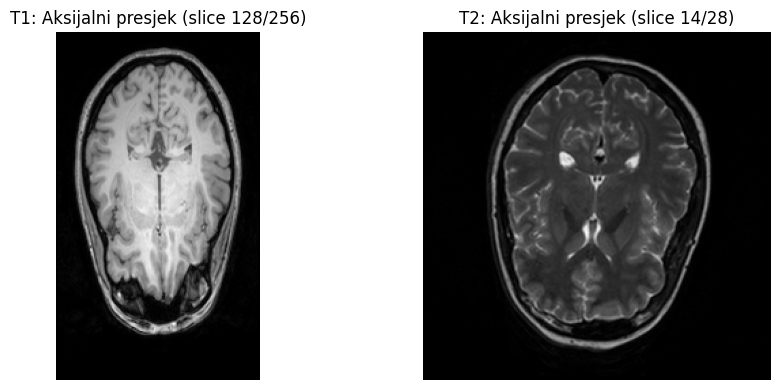

In [12]:
visualize_axial_slices_fixed("../dataset/raw_data/IXI-T1/IXI014-HH-1236-T1.nii.gz", "../dataset/raw_data/IXI-T2/IXI014-HH-1236-T2.nii.gz", slice_percentage=0.5)

In [13]:
def extract_resolutions(paths):
    resolution_0 = []
    resolution_1 = []
    resolution_2 = []
    for path in paths:
        try:
            img = nib.load(path)
            resolution = img.header.get_zooms()
            resolution_0.append(float(resolution[0]))
            resolution_1.append(float(resolution[1]))
            resolution_2.append(float(resolution[2]))
        except Exception as e:
            print(f"Greška kod slike {os.path.basename(path)}: {e}")
    return resolution_0, resolution_1, resolution_2

def calculate_basic_statistics(data):
    return {
        'min': np.min(data),
        'max': np.max(data),
        'mean': np.mean(data),
        'std': np.std(data),
        'median': np.median(data)
    }

In [14]:
def analyze_resolution_statistics(t1_paths, t2_paths):
    # Za T1 orijentacija je ('P', 'S', 'R')
    # P: posterior-anterior (natrag-naprijed)
    # S: superior-inferior (gore-dolje)
    # R: right-left (desno-lijevo)
    
    # Za T2 orijentacija je ('L', 'A', 'S')
    # L: left-right (lijevo-desno)
    # A: anterior-posterior (naprijed-natrag)
    # S: superior-inferior (gore-dolje)
    
    t1_posterior_anterior, t1_superior_inferior, t1_right_left = [], [], []
    t2_left_right, t2_anterior_posterior, t2_superior_inferior = [], [], []  

    print(f"Prikupljanje podataka o rezoluciji za {len(t1_paths)} T1 slika...")
    t1_posterior_anterior, t1_superior_inferior, t1_right_left = extract_resolutions(t1_paths)
    
    print(f"Prikupljanje podataka o rezoluciji za {len(t2_paths)} T2 slika...")
    t2_left_right, t2_anterior_posterior, t2_superior_inferior = extract_resolutions(t2_paths)
    
    # Računanje statistika za T1
    t1_stats_posterior_anterior = calculate_basic_statistics(t1_posterior_anterior)
    t1_stats_superior_inferior = calculate_basic_statistics(t1_superior_inferior)
    t1_stats_right_left = calculate_basic_statistics(t1_right_left)
    
    # Računanje statistika za T2
    t2_stats_left_right = calculate_basic_statistics(t2_left_right)
    t2_stats_anterior_posterior = calculate_basic_statistics(t2_anterior_posterior)
    t2_stats_superior_inferior = calculate_basic_statistics(t2_superior_inferior)

    
    print("\nStatistike rezolucije za T1 slike (mm):")
    print(f"  Natrag-Naprijed (P): min={t1_stats_posterior_anterior['min']:.6f}, max={t1_stats_posterior_anterior['max']:.6f}, srednja={t1_stats_posterior_anterior['mean']:.6f} ± {t1_stats_posterior_anterior['std']:.6f}, medijan={t1_stats_posterior_anterior['median']:.6f}")
    print(f"  Gore-Dolje (S): min={t1_stats_superior_inferior['min']:.6f}, max={t1_stats_superior_inferior['max']:.6f}, srednja={t1_stats_superior_inferior['mean']:.6f} ± {t1_stats_superior_inferior['std']:.6f}, medijan={t1_stats_superior_inferior['median']:.6f}")
    print(f"  Desno-Lijevo (R): min={t1_stats_right_left['min']:.6f}, max={t1_stats_right_left['max']:.6f}, srednja={t1_stats_right_left['mean']:.6f} ± {t1_stats_right_left['std']:.6f}, medijan={t1_stats_right_left['median']:.6f}")
    
    print("\nStatistike rezolucije za T2 slike (mm):")
    print(f"  Lijevo-Desno (L): min={t2_stats_left_right['min']:.6f}, max={t2_stats_left_right['max']:.6f}, srednja={t2_stats_left_right['mean']:.6f} ± {t2_stats_left_right['std']:.6f}, medijan={t2_stats_left_right['median']:.6f}")
    print(f"  Naprijed-Natrag (A): min={t2_stats_anterior_posterior['min']:.6f}, max={t2_stats_anterior_posterior['max']:.6f}, srednja={t2_stats_anterior_posterior['mean']:.6f} ± {t2_stats_anterior_posterior['std']:.6f}, medijan={t2_stats_anterior_posterior['median']:.6f}")
    print(f"  Gore-Dolje (S): min={t2_stats_superior_inferior['min']:.6f}, max={t2_stats_superior_inferior['max']:.6f}, srednja={t2_stats_superior_inferior['mean']:.6f} ± {t2_stats_superior_inferior['std']:.6f}, medijan={t2_stats_superior_inferior['median']:.6f}")
    
    return {
        't1': {
            'posterior_anterior': t1_stats_posterior_anterior,
            'superior_inferior': t1_stats_superior_inferior,
            'right_left': t1_stats_right_left,
            'raw_data': {
                'posterior_anterior': t1_posterior_anterior,
                'superior_inferior': t1_superior_inferior,
                'right_left': t1_right_left
            }
        },
        't2': {
            'left_right': t2_stats_left_right,
            'anterior_posterior': t2_stats_anterior_posterior,
            'superior_inferior': t2_stats_superior_inferior,
            'raw_data': {
                'left_right': t2_left_right,
                'anterior_posterior': t2_anterior_posterior,
                'superior_inferior': t2_superior_inferior
            }
        }
    }


resolution_stats = analyze_resolution_statistics(t1_files, t2_files)

Prikupljanje podataka o rezoluciji za 577 T1 slika...
Prikupljanje podataka o rezoluciji za 577 T2 slika...

Statistike rezolucije za T1 slike (mm):
  Natrag-Naprijed (P): min=0.937486, max=0.976562, srednja=0.937838 ± 0.003621, medijan=0.937500
  Gore-Dolje (S): min=0.937486, max=0.976562, srednja=0.937839 ± 0.003620, medijan=0.937500
  Desno-Lijevo (R): min=1.199993, max=1.200008, srednja=1.200000 ± 0.000003, medijan=1.200000

Statistike rezolucije za T2 slike (mm):
  Lijevo-Desno (L): min=0.898438, max=0.976562, srednja=0.937365 ± 0.003250, medijan=0.937500
  Naprijed-Natrag (A): min=0.898438, max=0.976562, srednja=0.937364 ± 0.003250, medijan=0.937500
  Gore-Dolje (S): min=1.199996, max=4.977778, srednja=1.249195 ± 0.156379, medijan=1.250000


In [15]:
def find_outlier_images(t1_t2_pairs):
    outliers_ids = []
    for t1_path, t2_path in t1_t2_pairs:
        t2_img = nib.load(t2_path)
        t2_shape = t2_img.shape
        t2_spacing = t2_img.header.get_zooms()
        
        # Provjeri je li ovo outlier slika
        is_outlier = False
        reason = ""
        
        if t2_shape == (256, 256, 28):
            is_outlier = True
            reason = "dimenzije 256x256x28"
        
        if abs(t2_spacing[2] - 4.98) < 0.1:
            is_outlier = True
            reason += " i rezolucija ~4.98mm" if reason else "rezolucija ~4.98mm"
        
        if is_outlier:
            t1_img = nib.load(t1_path)
            
            print(f"\nPronađen outlier: {reason}")
            print(f"T2 slika: {os.path.basename(t2_path)}")
            print(f"  Dimenzije: {t2_shape}, Rezolucija: {t2_spacing} mm")
            
            print(f"T1 slika: {os.path.basename(t1_path)}")
            print(f"  Dimenzije: {t1_img.shape}, Rezolucija: {t1_img.header.get_zooms()} mm")
            outliers_ids.append(extract_subject_id(t2_path))
    return outliers_ids
    
outliers = find_outlier_images(t1_with_pairs)


Pronađen outlier: dimenzije 256x256x28 i rezolucija ~4.98mm
T2 slika: IXI014-HH-1236-T2.nii.gz
  Dimenzije: (256, 256, 28), Rezolucija: (np.float32(0.8984375), np.float32(0.8984375), np.float32(4.977778)) mm
T1 slika: IXI014-HH-1236-T1.nii.gz
  Dimenzije: (256, 256, 150), Rezolucija: (np.float32(0.9375), np.float32(0.9375), np.float32(1.2000002)) mm


S obizirom na ovaj ispitanik ima značajno manje rezova u z-smjeru T2 skena od ostalih, moglo bi doći do problema u budućoj registraciji. Vidimo da taj ispitanik također ima rezoluciju od 4.98mm koja jako odskače od ostalih. Ovog ispitanik smatramo outlierom i izbaciti ćemo ga iz našeg skupa.

In [16]:
#brisanje outlier slika
for outlier in outliers:
    t1_path_outlier = t1_ids[outlier]
    t2_path_outlier = t2_ids[outlier]
    
    print(f"Brisanje outlier slike: {outlier}")
    os.remove(t1_path_outlier)
    os.remove(t2_path_outlier)

    t1_ids.pop(outlier)
    t2_ids.pop(outlier)

Brisanje outlier slike: IXI014


In [ ]:
#makni IXI dio iz outlier liste tako da smao ostane id
outliers_id = [int(o.replace('IXI', '')) for o in outliers]
#brisanje outliera iz metapodataka
metadata_df = pd.read_csv('../dataset/data/IXI_metadata.csv')
metadata_df = metadata_df[~metadata_df['IXI_ID'].isin(outliers_id)]

In [20]:
metadata_df.to_csv('../dataset/data/IXI_metadata_for_process.csv', index=False)

In [19]:
#provjeri broj slika nakon brisanja outlier slika
t1_files = sorted(glob.glob(os.path.join(t1_dir, "*.nii*")))
t2_files = sorted(glob.glob(os.path.join(t2_dir, "*.nii*")))
print(f"\nPreostalo {len(t1_files)} T1 skenova i {len(t2_files)} T2 skenova.")


Preostalo 576 T1 skenova i 576 T2 skenova.


In [21]:
#ispis novih statistika
t1_dimensions, t2_dimensions = check_image_dimensions(t1_files, t2_files)
resolution_stats = analyze_resolution_statistics(t1_files, t2_files)

Provjera dimenzija za 576 T1 slika...
Provjera dimenzija za 576 T2 slika...

Dimenzije T1 slika:
  Dimenzije (256, 256, 150): 499 slika (86.6%)
  Dimenzije (256, 256, 140): 2 slika (0.3%)
  Dimenzije (256, 256, 130): 2 slika (0.3%)
  Dimenzije (256, 256, 146): 73 slika (12.7%)

Dimenzije T2 slika:
  Dimenzije (256, 256, 130): 492 slika (85.4%)
  Dimenzije (256, 256, 112): 1 slika (0.2%)
  Dimenzije (256, 256, 116): 1 slika (0.2%)
  Dimenzije (256, 256, 120): 8 slika (1.4%)
  Dimenzije (256, 256, 125): 1 slika (0.2%)
  Dimenzije (256, 256, 136): 73 slika (12.7%)
Prikupljanje podataka o rezoluciji za 576 T1 slika...
Prikupljanje podataka o rezoluciji za 576 T2 slika...

Statistike rezolucije za T1 slike (mm):
  Natrag-Naprijed (P): min=0.937486, max=0.976562, srednja=0.937839 ± 0.003624, medijan=0.937500
  Gore-Dolje (S): min=0.937486, max=0.976562, srednja=0.937839 ± 0.003624, medijan=0.937500
  Desno-Lijevo (R): min=1.199993, max=1.200008, srednja=1.200000 ± 0.000003, medijan=1.200000
